In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 23 10:11:40 2018

@author: svd
"""

import os
import io
import re
import numpy as np
import scipy.io
#import nems.recording as Recording
import pandas as pd
import matplotlib.pyplot as plt

import nems.utilities as nu
import nems.db as nd
import nems.utilities.baphy


# figure out filepath for demo files

cellid='TAR010c-07-1'
batch=271
# database can be used to locate files, but need to configure nems
#d=nd.get_batch_cell_data(cellid=cellid,batch=batch,label='parm')
#parmfilepath=d['parm'][0]
# less responsive site
#parmfilepath='/auto/data/daq/Babybell/bbl086/bbl086b09_p_NAT.m'
#several units recorded here
parmfilepath='/auto/data/daq/Tartufo/TAR010/TAR010c16_p_NAT.m'

options={'rasterfs': 100, 'includeprestim': True, 'stimfmt': 'ozgf', 'chancount': 18, 'cellid': 'all', 'pupil': True}
event_times, spike_dict, stim_dict, state_dict = nu.baphy.baphy_load_recording(parmfilepath,options)


# compute raster for specific unit and stimulus id with sampling rate rasterfs
unitidx=0 # which unit
eventidx=1

stimevents=list(stim_dict.keys())
cellids=list(spike_dict.keys())

event_name=stimevents[eventidx]
cellid=cellids[unitidx]

#event_name='TRIAL'

binlen=1.0/options['rasterfs']
h=np.array([])
ff = (event_times['name']==event_name)

Cached stim: /auto/data/tmp/tstim/NaturalSounds-2-0.5-3-1-White______-100-0-3__8-65dB-ozgf-fs100-ch18-incps1.mat
Spike file: /auto/data/daq/Tartufo/TAR010/sorted/TAR010c16_p_NAT.spk.mat
rounding Trial offset spike times to even number of rasterfs bins
342 trials totaling 2076.12 sec
Creating trial events
Creating trial outcome events
Removing post-response stimuli
Keeping 2394/2394 events that precede responses


In [4]:
event_times.loc[ff]

,start,end,name
2,0,5.5,00ferretmixed41.wav
12,11.94,17.44,00ferretmixed41.wav
72,84.14,89.64,00ferretmixed41.wav
132,156.41,161.91,00ferretmixed41.wav
212,253.01,258.51,00ferretmixed41.wav
252,301.32,306.82,00ferretmixed41.wav
342,409.53,415.03,00ferretmixed41.wav
482,578.28,583.78,00ferretmixed41.wav
717,862.22,867.72,00ferretmixed41.wav
747,897.9,903.4,00ferretmixed41.wav


In [5]:
## pull out each epoch from the spike times, generate a raster of spike rate
for i,d in event_times.loc[ff].iterrows():
    print("{0}-{1}".format(d['start'],d['end']))
    edges=np.arange(d['start'],d['end']+binlen,binlen)
    th,e=np.histogram(spike_dict[cellid],edges)
    
    print("{0}-{1}: {2}".format(edges[0],edges[1],sum((spike_dict[cellid]>edges[0]) & (spike_dict[cellid]<edges[1]))))
    th=np.reshape(th,[1,-1])
    if h.size==0:
        # lazy hack: intialize the raster matrix without knowing how many bins it will require
        h=th
    else:
        # concatenate this repetition, making sure binned length matches
        if th.shape[1]<h.shape[1]:
            h=np.concatenate((h,np.zeros([1,h.shape[1]])),axis=0)
            h[-1,:]=np.nan
            h[-1,:th.shape[1]]=th
        else:
            h=np.concatenate((h,th[:,:h.shape[1]]),axis=0)
    
m=np.nanmean(h,axis=0)

0.0-5.5
0.0-0.01: 0
11.94-17.439999999999998
11.94-11.95: 1
84.14-89.64
84.14-84.15: 0
156.41-161.91
156.41-156.42: 0
253.01-258.51
253.01-253.01999999999998: 0
301.32-306.82
301.32-301.33: 0
409.53-415.03
409.53-409.53999999999996: 1
578.28-583.78
578.28-578.29: 0
862.22-867.72
862.22-862.23: 0
897.9-903.4
897.9-897.91: 0
1018.58-1024.08
1018.58-1018.59: 1
1024.65-1030.15
1024.65-1024.66: 0
1151.77-1157.27
1151.77-1151.78: 1
1230.58-1236.08
1230.58-1230.59: 0
1260.55-1266.05
1260.55-1260.56: 0
1340.05-1345.55
1340.05-1340.06: 0
1389.15-1394.65
1389.15-1389.16: 0
1431.29-1436.79
1431.29-1431.3: 0
1534.46-1539.96
1534.46-1534.47: 0
1613.78-1619.28
1613.78-1613.79: 0
1631.88-1637.38
1631.88-1631.89: 0
1638.02-1643.52
1638.02-1638.03: 0
1662.15-1667.65
1662.15-1662.16: 1
1741.24-1746.74
1741.24-1741.25: 0


In [283]:
# plt.plot(spike_dict['TAR010c-02-1'])
# plt.imshow(stim_dict['00Oxford_male2b.wav'], aspect='auto')
# k = np.array(stim_dict.keys()[0])
# stim_dict.shape

#list(spike_dict.keys()).count(stim_dict(0))
#stim_dict.keys()

wavEvents = event_times[event_times['name'].str.contains('.wav')]
occurences =  wavEvents['name'].value_counts(sort=True)

Train_names = list(occurences[occurences==3].index)
Test_names = list(occurences[occurences==24].index)


Train_times = pd.DataFrame(columns={'name','start','end'})
Train_times = Train_times[['name','start','end']] #Order the columns
Test_times = Train_times.copy()

#Get stimuli onset and offset times for trains
trial_indexs = event_times['name'][event_times['name']=='TRIAL'].index
idx1 = 0; idx2 = 0;
for trial_idx in trial_indexs:
    name = event_times.iloc[trial_idx+1]['name']
    if name in Train_names :
        Train_times.at[idx1,'name'] = name
        Train_times.at[idx1,'start'] = event_times.iloc[trial_idx+3]['end']
        Train_times.at[idx1,'end'] = event_times.iloc[trial_idx+4]['start']
        idx1 +=1
    elif name in Test_names :
        Test_times.at[idx2,'name'] = name
        Test_times.at[idx2,'start'] = event_times.iloc[trial_idx+3]['end']
        Test_times.at[idx2,'end'] = event_times.iloc[trial_idx+4]['start']
        idx2 +=1
    else : 
        raise ValueError('Neither a Test nor a Train stimuli name')
        
Train_times = Train_times.sort_values('name')
Test_times = Test_times.sort_values('name')

Train_times
#Test_times
#Train_times['Name'].loc[0]= 'lb'

#event_times.iloc[0]['name']
#event_times

#event_times
#Train_times
#print(stim_dict.keys())
#event_times

,name,start,end
266,ASE-04_Frying_Eggs.wav,2046.73,2049.73
158,ASE-04_Frying_Eggs.wav,1195.94,1198.94
44,ASE-04_Frying_Eggs.wav,345.35,348.35
22,ASE-05_Blender.wav,176.48,179.48
188,ASE-05_Blender.wav,1452.49,1455.49
155,ASE-05_Blender.wav,1177.77,1180.77
77,ASE-49_Wind_Chimes.wav,604.62,607.62
181,ASE-49_Wind_Chimes.wav,1397.12,1400.12
121,ASE-49_Wind_Chimes.wav,918.05,921.05
12,ASE-53_Electric_Grinding_Wheel.wav,92.09,95.09


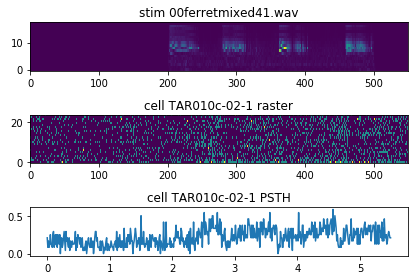

In [7]:
plt.figure()
plt.subplot(3,1,1)
plt.imshow(stim_dict[event_name],origin='lower',aspect='auto')
plt.title("stim {0}".format(event_name))
plt.subplot(3,1,2)
plt.imshow(h,origin='lower',aspect='auto')
plt.title("cell {0} raster".format(cellid))
plt.subplot(3,1,3)
plt.plot(np.arange(len(m))*binlen,m)
plt.title("cell {0} PSTH".format(cellid))
plt.tight_layout()



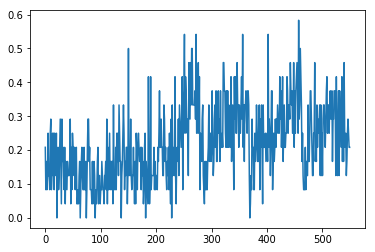

In [9]:
plt.plot(m)